# 07 - Making and using hostart files

## Using PAVICS-Hydro to create a hotstart file to resume a simulation from given hydrological conditions

Here we run a hydrological model with `Raven` over a long period. Then we run the model on half of the period, save the final states, and then run the second half in an independent run but using the model states at the end of the first half. This should provide two (2) hydrographs that are exactly equal.

In [1]:
import datetime as dt

import xarray as xr
from ravenpy.utilities.testdata import get_file

At this point the following block of code should be quite familiar! If not, please go back to notebook "04 - Emulating hydrological models" to understand what is happening.

In [2]:
# Import the GR4JCN model
from ravenpy.models import GR4JCN

# Get the forcing data from the external source. You can change this to insert your own files of course.
forcing = get_file(
    "raven-gr4j-cemaneige/Salmon-River-Near-Prince-George_meteo_daily.nc"
)

# Generate a GR4JCN-configured Raven model instance.
model = GR4JCN()

# Define the hydrological response unit. We can use the information from the tutorial notebook #02! Here we are using
# arbitrary data for a test catchment.
hru = GR4JCN.LandHRU(
    area=4250.6, elevation=843.0, latitude=54.4848, longitude=-123.3659
)

# Here is where we launch the model using all sorts of configuration parameters. Note that we are using 2 years, i.e. 2000-2001 inclusively.
model(
    forcing,
    start_date=dt.datetime(2000, 1, 1),
    end_date=dt.datetime(2001, 12, 31),
    hrus=(
        hru,
    ),  # Careful how this must be passed! This is due to the capability of running in distributed mode as well.
    params=(0.529, -3.396, 407.29, 1.072, 16.9, 0.947),
    run_name="Salmon",
    overwrite=True,
)

/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: Initial conditions specified for state variable not in model (DEPRESSION)
  warn(msg, category=RavenWarning)
/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: Gauge:Initialize: both snowfall and rainfall data are provided at a gauge, but :RainSnowFraction method is something other than RAINSNOW_DATA. Snow fraction will be recalculated.
  warn(msg, category=RavenWarning)
/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: PET data supplied at gauge Gauge1 but will not be used due to choice of forcing generation algorithm
  warn(msg, category=RavenWarning)
/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: CModelInitialize: if a non-standard calendar is used, all observation data must be converted into the same calendar format
  warn(msg, category=RavenWarning)
/opt/conda/envs

Now that we have run the model, we can extract the hydrograph:

In [3]:
first_hydrograph = model.hydrograph.q_sim

### Now let's see if we can replicate the hydrograph using a hotstart file. 
First, run the model without a hotstart file, same as before, but only for one year:


In [4]:
# We create a NEW model instance, to ensure we don't accidentaly keep information from the previous model instance.
model = GR4JCN()

# Run the model, this time only with one year (2000).
model(
    forcing,
    start_date=dt.datetime(2000, 1, 1),
    end_date=dt.datetime(2000, 12, 31),
    area=4250.6,
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
    params=(0.529, -3.396, 407.29, 1.072, 16.9, 0.947),
    run_name="Salmon",
    overwrite=True,
)

# Extract the hydrograph for this first year.
second_hydrograph_first_year = model.hydrograph.q_sim

# Now we can get the path to the state variables for the end of the simulation. This will allow us to start a new simulation from these same states.
hotstart_states = model.outputs["solution"]

/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: Initial conditions specified for state variable not in model (DEPRESSION)
  warn(msg, category=RavenWarning)
/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: Gauge:Initialize: both snowfall and rainfall data are provided at a gauge, but :RainSnowFraction method is something other than RAINSNOW_DATA. Snow fraction will be recalculated.
  warn(msg, category=RavenWarning)
/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: PET data supplied at gauge Gauge1 but will not be used due to choice of forcing generation algorithm
  warn(msg, category=RavenWarning)
/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: CModelInitialize: if a non-standard calendar is used, all observation data must be converted into the same calendar format
  warn(msg, category=RavenWarning)
/opt/conda/envs

Now, let's run the model using the hotstart but for the second year only. Notice that we have a new configuration variable called "rvc". This is where we can provide the path to the starting conditions!

In [5]:
# Again, create a new model instance to ensure we are not cheating somehow, so overwrite with a blank model instance.
model = GR4JCN()

# Run the model, but this time using the second year only (2001). We start at 2000,12,31 since that is the day the last states were saved.
model(
    forcing,
    start_date=dt.datetime(2000, 12, 31),
    end_date=dt.datetime(2001, 12, 31),
    area=4250.6,
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
    params=(0.529, -3.396, 407.29, 1.072, 16.9, 0.947),
    run_name="Salmon",
    rvc=str(hotstart_states),
)

# Extract the hydrograph for the second year
second_hydrograph_second_year = model.hydrograph.q_sim

/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: Initial conditions specified for state variable not in model (DEPRESSION)
  warn(msg, category=RavenWarning)
/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: Gauge:Initialize: both snowfall and rainfall data are provided at a gauge, but :RainSnowFraction method is something other than RAINSNOW_DATA. Snow fraction will be recalculated.
  warn(msg, category=RavenWarning)
/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: PET data supplied at gauge Gauge1 but will not be used due to choice of forcing generation algorithm
  warn(msg, category=RavenWarning)
/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: CModelInitialize: if a non-standard calendar is used, all observation data must be converted into the same calendar format
  warn(msg, category=RavenWarning)
/opt/conda/envs

Now that we have calculated both hydrographs separately, let's concatenate them into a single array of 2-years duration.

In [6]:
second_hydrograph_complete = xr.concat(
    [second_hydrograph_first_year[0:-1], second_hydrograph_second_year], "time"
)

## Plotting both hydrographs
Let's plot both hydrographs to see if they are the same:

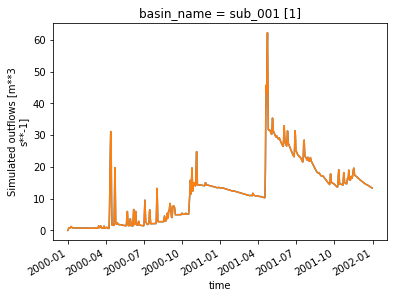

In [7]:
first_hydrograph.plot()
second_hydrograph_complete.plot()

And now if we look at the difference between both hydrographs:

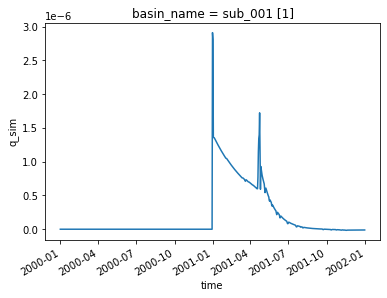

In [8]:
difference = first_hydrograph - second_hydrograph_complete
difference.plot()

We can see that differences are at machine precision levels, due to rounding in the hotstart file (note that the y-axis is 1e-6, which is essentially 0!). But the rest is perfect!

Therefore, we can provide forecasting abilities by saving simulation final states and using those to initialize model states for the forecasting runs. This will be used in other notebooks such as notebook #12 on hindcasting.
